# Synthetic Drift Injection Examples 

These examples show how to set up and apply the synthetic drift injectors in the injection module. The following examples use the Rainfall dataset, a real source of weather data. We use the first 1000 samples, where no drift has been injected. 

As true drift is rarely known, these synthetic drift injectors are useful for validating drift detector performance and calibrating detector parameters

In [26]:
## Imports ##

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from menelaus.injection.feature_manipulation import FeatureShiftInjector, FeatureSwapInjector, FeatureCoverInjector
from menelaus.injection.noise import BrownianNoiseInjector
from menelaus.injection.label_manipulation import LabelProbabilityInjector, LabelJoinInjector, LabelSwapInjector, LabelDirichletInjector
from menelaus.datasets import fetch_rainfall_data, make_example_batch_data


In [27]:
## Import Data ##
rainfall_df = fetch_rainfall_data()

## Feature Manipulation

### Feature Shift Injector

This injector shifts the distribution of a single feature by a fixed value. The fixed value is a function of the mean to ensure the shift is relative to the feature valeus. An alpha parameter is added to ensure the distribution shifts for cases where the mean of the feature is 0.

In [28]:
## Setup ##

palette = sns.color_palette("Spectral", 10).as_hex()

# Make a copy of original dataframe
df = rainfall_df.copy()

# Identify the column you want to inject drift
col = 'average_wind_speed'

# Introduce drift injector
injector = FeatureShiftInjector()

# Identify max and min of feature for plotting 
max = np.max(df[col])
min = np.min(df[col])

# Inject drift into desired start and end indices
# Returns df containing drift 
drift_start = 8000
drift_end = 12000

# Shift data by 50% of mean, add initial alpha value of 1
df = injector(df, drift_start, drift_end, col, 0.5, alpha = 1)

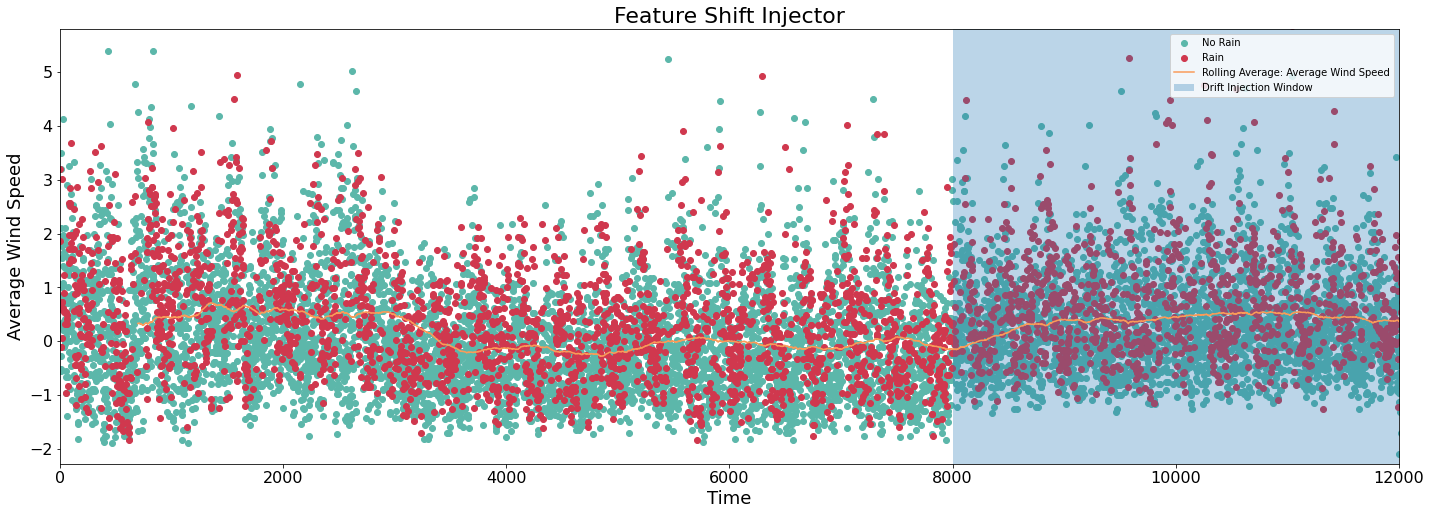

In [29]:
## Plotting ##

# Create two scatter plots for outcome labels 
plt.figure(figsize=(24, 8))
df0 = df.loc[df['rain'] == 0]
df1 = df.loc[df['rain'] == 1]
plt.scatter(df0.index, df0[col], c = palette[8]) 
plt.scatter(df1.index, df1[col], c = palette[0]) 

# Add rolling mean of column 
df['rolling_mean'] = df[col].rolling(700).mean()
plt.plot(df['rolling_mean'], color = palette[2] , label = 'Running Average')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Feature Shift Injector', fontsize=22)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Average Wind Speed', fontsize=18)
plt.xlim((0,12000))
plt.ylim((min,max)) # limit y to show more informative plot
plt.axvspan(drift_start, drift_end, alpha=0.3, label='Drift Injection Window')
# apply legend()
plt.legend(["No Rain" , "Rain","Rolling Average: Average Wind Speed", "Drift Injection Window"],loc = 'upper right')

### Feature Swap Injector

This injector swaps the values of two features. It's for use with features that have standardized values or values within a similar range.

In [30]:
## Setup ##

palette = sns.color_palette("Spectral", 10).as_hex()

# Make a copy of original dataframe
df = rainfall_df.copy()

# Identify the column you want to inject drift
col1 = 'average_wind_speed'
col2 = 'visibility'

# Introduce drift injector
injector = FeatureSwapInjector()

# Inject drift into desired start and end indices
# Returns df containing drift 
drift_start = 8000
drift_end = 12000

# Swap values of column 1 and 2
df = injector(df, drift_start, drift_end, col1, col2)

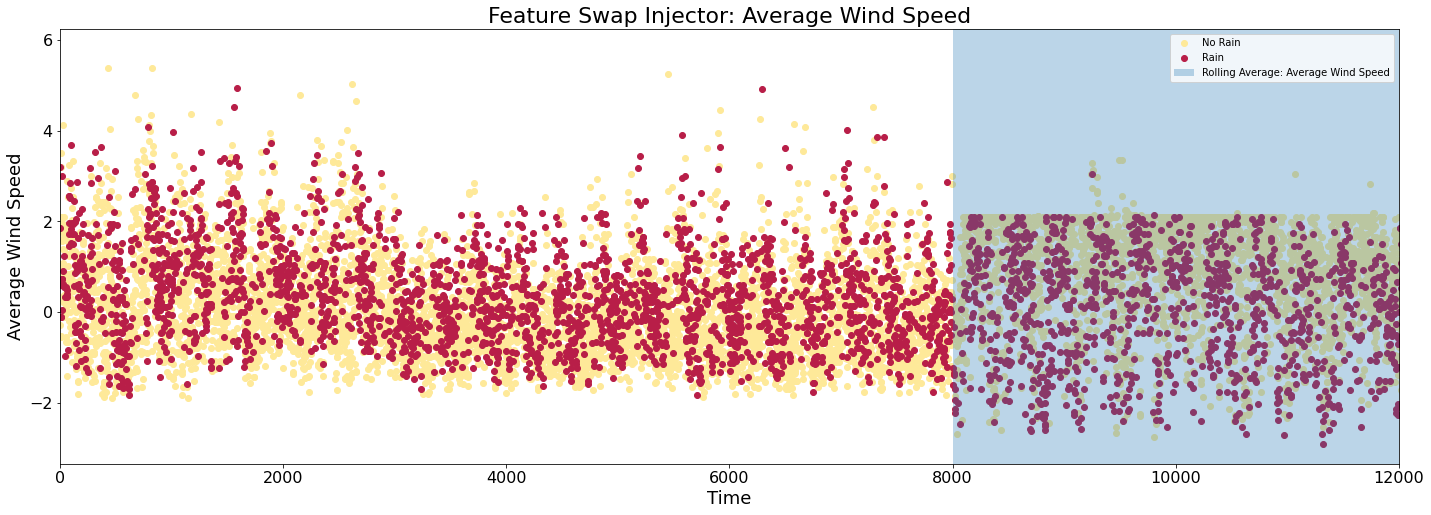

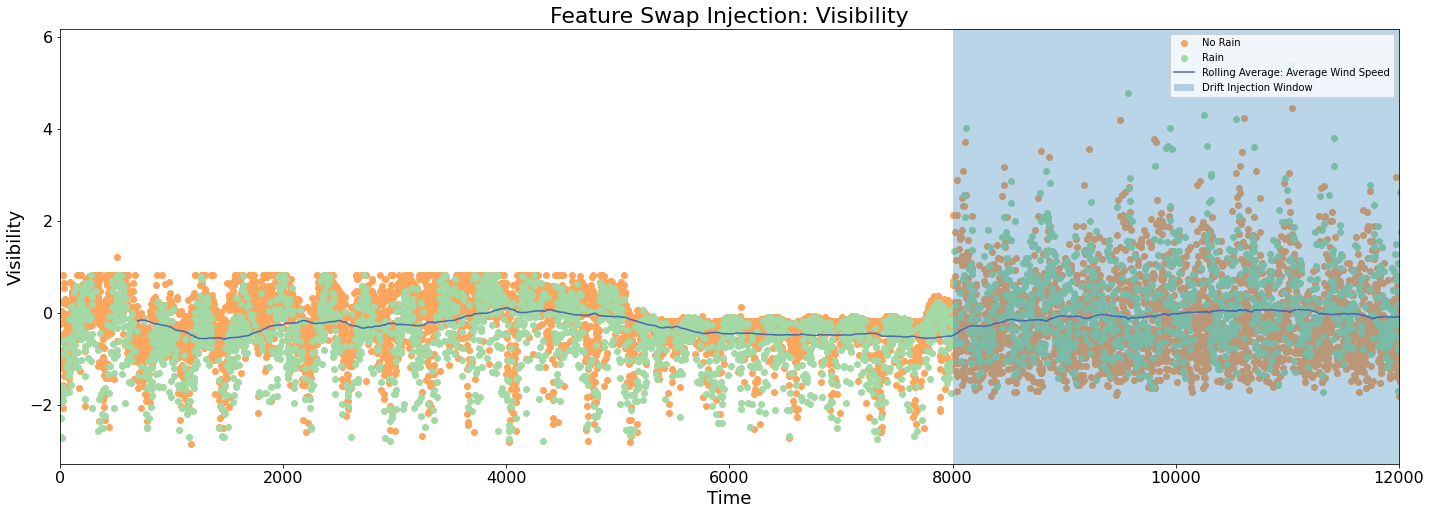

In [31]:
## Plotting ##

palette = sns.color_palette("Spectral", 20).as_hex()

# Plot for first column 
plt.figure(1,figsize=(24,8))
df0 = df.loc[df['rain'] == 0]
df1 = df.loc[df['rain'] == 1]
plt.scatter(df0.index, df0[col1], c = palette[8]) 
plt.scatter(df1.index, df1[col1], c = palette[0])
# Add rolling mean of column 
#df['rolling_mean_column1'] = df[col1].rolling(700).mean()
#plt.plot(df['rolling_mean_column1'], color = palette[17] , label = 'Running Average')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Feature Swap Injector: Average Wind Speed', fontsize=22)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Average Wind Speed', fontsize=18)
plt.xlim((0,12000))
plt.axvspan(drift_start, drift_end, alpha=0.3, label='Drift Injection Window')
# apply legend()
plt.legend(["No Rain" , "Rain","Rolling Average: Average Wind Speed", "Drift Injection Window"],loc = 'upper right')

# Plot for second column
plt.figure(2,figsize=(24,8))
plt.scatter(df0.index, df0[col2], c = palette[5]) 
plt.scatter(df1.index, df1[col2], c = palette[14])
# Add rolling mean of column 
df['rolling_mean_column2'] = df[col2].rolling(700).mean()
plt.plot(df['rolling_mean_column2'], color = palette[19] , label = 'Running Average')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Feature Swap Injection: Visibility', fontsize=22)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Visibility', fontsize=18)
plt.xlim((0,12000))
plt.axvspan(drift_start, drift_end, alpha=0.3, label='Drift Injection Window')
# apply legend()
plt.legend(["No Rain" , "Rain","Rolling Average: Average Wind Speed", "Drift Injection Window"],loc = 'upper right')
plt.show()

### Feature Cover Injector

This injector groups data by a categorical feature, uniformly samples from each group, and "hides" the feature. It can be used to simulate changes in a dataset relative to a hidden category. 

In [32]:
## Setup ##

palette = sns.color_palette("Spectral", 10).as_hex()

# Make a copy of original dataframe
df = rainfall_df.copy()

# Identify the column you want to inject drift
col = 'rain'

# Introduce drift injector
injector = FeatureCoverInjector()

# Inject drift into a dataframe of desired sample size
# Returns df containing drift 
sample_size = 1000

df = injector(df, col,sample_size)

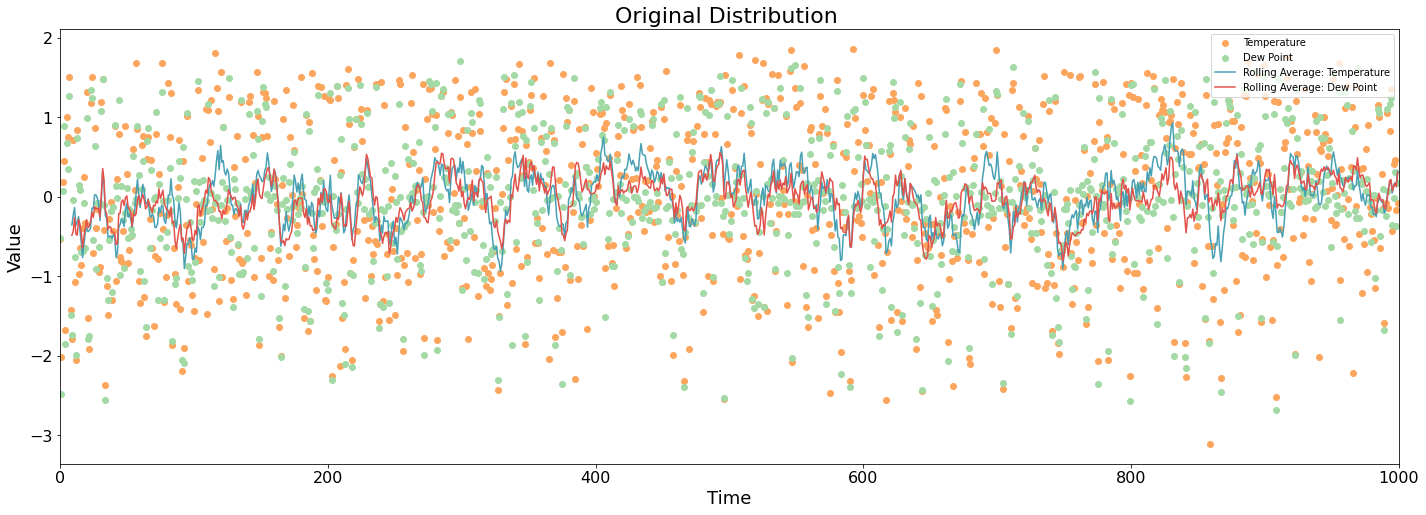

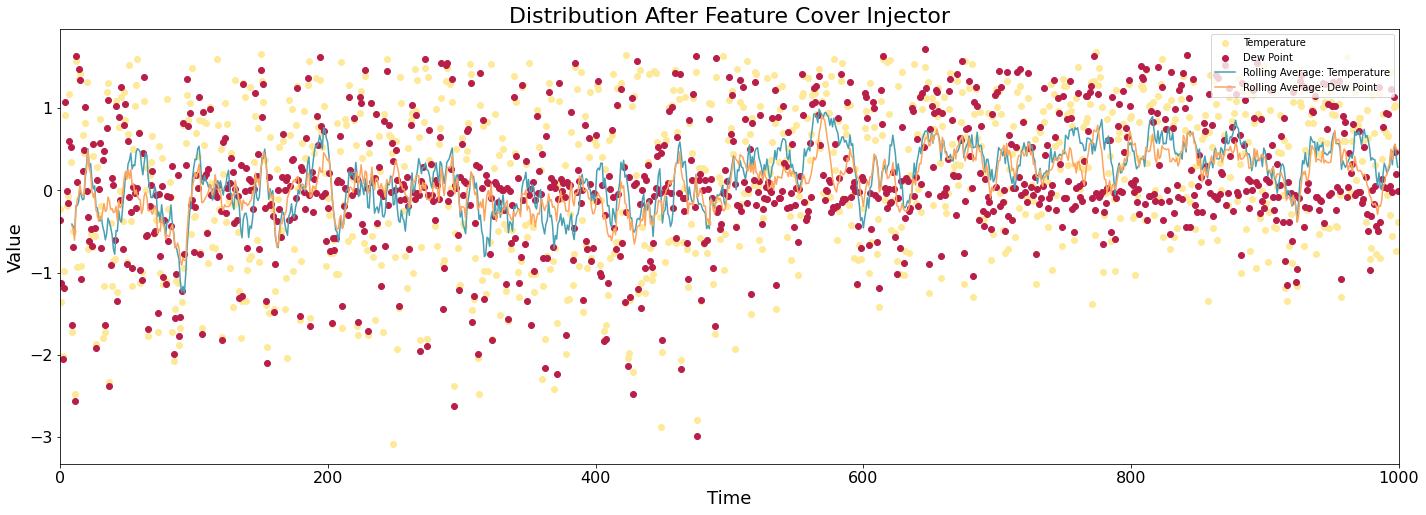

In [33]:
## Plotting ##

palette = sns.color_palette("Spectral", 20).as_hex()

col1 = 'temperature'
col2 = 'dew_point'

# Plot distribution before injection
plt.figure(1,figsize=(24,8))
orig_df = rainfall_df.sample(n=1000)
orig_df.reset_index(inplace = True)
# Create different scatter plots for types of intrusions 
plt.scatter(orig_df.index, orig_df[col1], c = palette[5]) 
plt.scatter(orig_df.index, orig_df[col2], c = palette[14])
# Add rolling mean 
orig_df['rolling_mean_column1'] = orig_df[col1].rolling(10).mean()
orig_df['rolling_mean_column2'] = orig_df[col2].rolling(10).mean()
plt.plot(orig_df['rolling_mean_column1'], color = palette[17] , label = 'Running Average')
plt.plot(orig_df['rolling_mean_column2'], color = palette[2] , label = 'Running Average')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Original Distribution ', fontsize=22)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.xlim((0,1000))
# apply legend()
plt.legend(["Temperature" , "Dew Point","Rolling Average: Temperature","Rolling Average: Dew Point","Drift Injection Window"],loc = 'upper right')


# Plot distribution after shift injection
plt.figure(2,figsize=(24,8))
plt.scatter(df.index, df[col1], c = palette[8]) 
plt.scatter(df.index, df[col2], c = palette[0])
# Add rolling mean 
df['rolling_mean_column1'] = df[col1].rolling(10).mean()
df['rolling_mean_column2'] = df[col2].rolling(10).mean()
plt.plot(df['rolling_mean_column1'], color = palette[17] , label = 'Running Average')
plt.plot(df['rolling_mean_column2'], color = palette[5] , label = 'Running Average')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Distribution After Feature Cover Injector', fontsize=22)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.xlim((0,1000))
# apply legend()
plt.legend(["Temperature" , "Dew Point","Rolling Average: Temperature","Rolling Average: Dew Point","Drift Injection Window"],loc = 'upper right')
plt.show()

## Noise 

### Brownian Noise Injector

This injector adds brownian noise to a feature. 

In [34]:
## Setup ##

# Make a copy of original dataframe
df = rainfall_df.copy()

# Identify the column you want to inject drift
col = 'average_wind_speed'

# Introduce drift injector
injector = BrownianNoiseInjector()

# Inject drift into a dataframe with desired start and end indices
drift_start = 8000
drift_end = 12000

# Setting class probabilities 
class_probabilities = {0: 0.15, 1: (1-0.15)}

# Injector returns df containing drift
df = injector(df, drift_start, drift_end, col, x0 = 1)



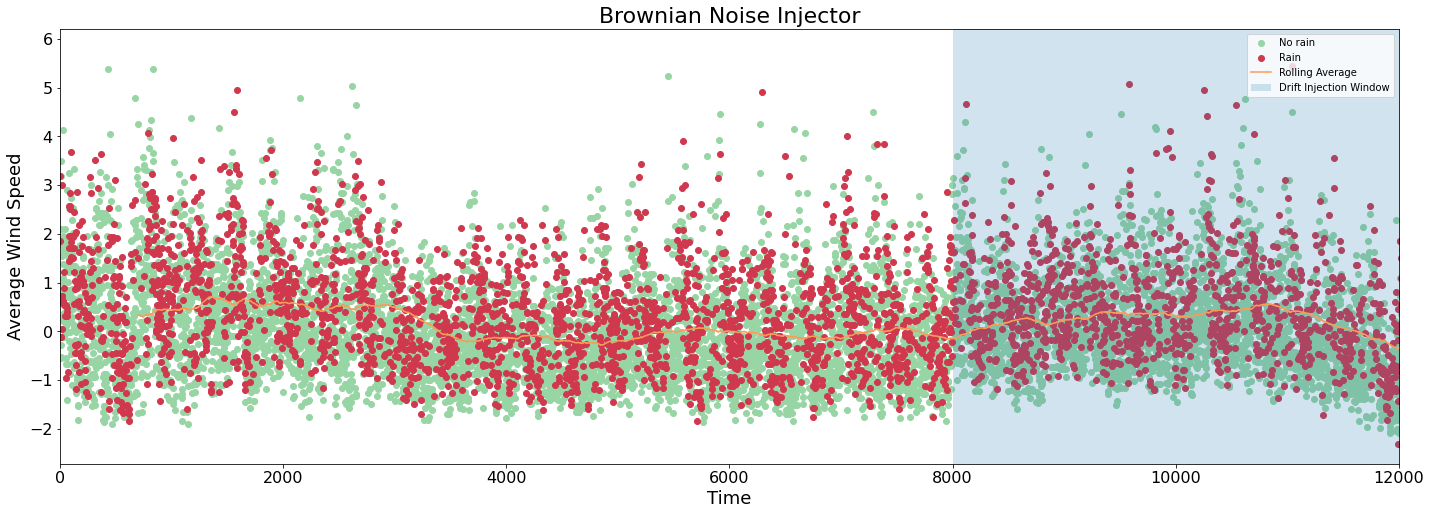

In [35]:
## Plotting ## 

palette = sns.color_palette("Spectral", 10).as_hex()

plt.figure(figsize=(24, 8))
df0 = df.loc[df['rain'] == 0]
df1 = df.loc[df['rain'] == 1]
plt.scatter(df0.index, df0[col], c = palette[7]) 
plt.scatter(df1.index, df1[col], c = palette[0]) 
# Add rolling mean 
df['rolling_mean'] = df[col].rolling(700).mean()
plt.plot(df['rolling_mean'], color = palette[2] , label = 'Running Average')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Brownian Noise Injector', fontsize=22)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Average Wind Speed', fontsize=18)
plt.xlim((0,12000))
plt.axvspan(drift_start, drift_end, alpha=0.2, label='Drift Injection Window')

plt.legend(["No rain" , "Rain",'Rolling Average','Drift Injection Window'], loc = 'upper right')


## Label Manipulation

### Label Swap Injector

This injector swaps two classes in a target column. 

In [36]:
## Setup ##

# Make a copy of original dataframe
df = rainfall_df.copy()

# Identify the column you want to inject drift
col = 'rain'

# Introduce drift injector
injector = LabelSwapInjector()

# Inject drift into a dataframe with desired start and end indices
# Returns df containing drift 
drift_start = 8000
drift_end = 12000

df = injector(df,drift_start,drift_end,col,1,0)

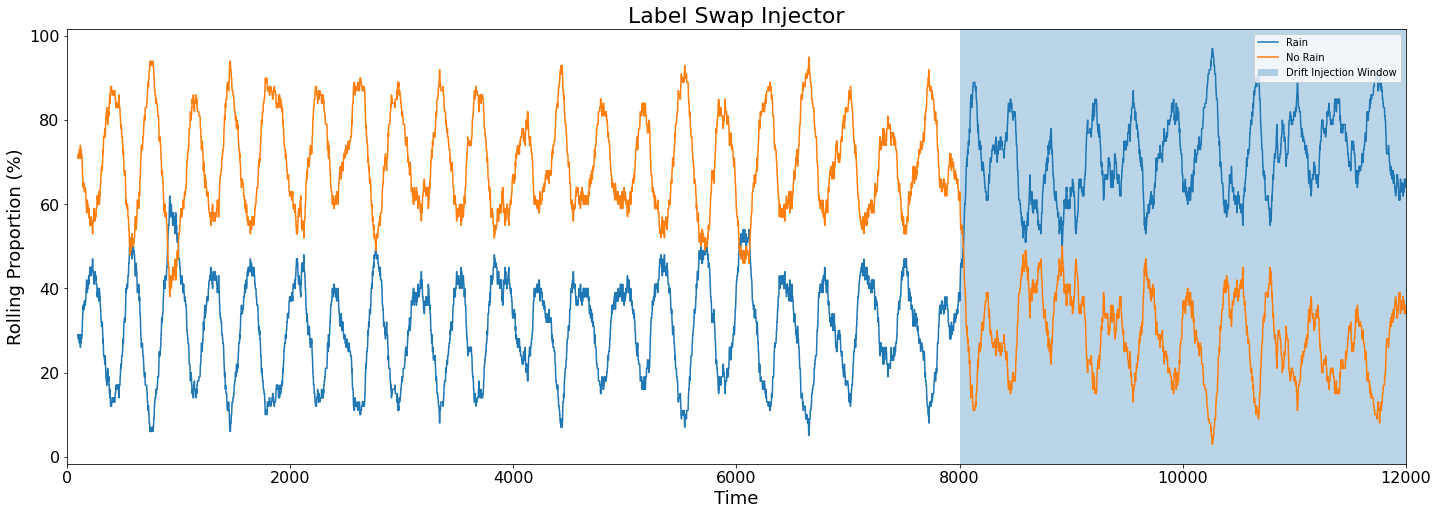

In [37]:
## Plotting ## 


palette = sns.color_palette("Spectral", 10).as_hex()

# setup rolling count of labels 
rolling_rain_1_count = df['rain'].rolling(100).sum()
rolling_rain_0_count = 100 - rolling_rain_1_count

plt.figure(figsize=(24,8))
plt.plot(df.index,rolling_rain_1_count, label = 'Rain Count')
plt.plot(df.index,rolling_rain_0_count, label = 'No-Rain Count')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Label Swap Injector', fontsize=22)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Rolling Proportion (%)', fontsize=18)
plt.xlim(0,12000)
plt.axvspan(drift_start, drift_end, alpha=0.3, label='Drift Injection Window')
#plt.legend()
plt.legend(["Rain","No Rain", 'Drift Injection Window'],loc = 'upper right')
plt.show()

### Label Join Injector

This injector joins two classes into a unique class and assigns the new class the label of one of the prior two classes. This injector is only applicable to a multinomial outcome variable. 

In this example, a synthetic dataset is used to show the example with a multinomial variable. Drift is injected into the label 'Cat', containing 4 categorical values, as 2 labels are joined together and combined with a third label. 

In [38]:
 ## Import Data ##
batch_df = make_example_batch_data()
batch_df = batch_df.iloc[0:12000]

In [39]:
## Setup ##

# Make a copy of original dataframe
df = batch_df.copy()

# Identify the column you want to inject drift
col = 'cat'

# Introduce drift injector
injector = LabelJoinInjector()

# Inject drift into a dataframe with desired start and end indices
# Returns df containing drift 
drift_start = 8000
drift_end = 12000

# Join cat=0 and cat=1 together and assign label 2
df = injector(df,drift_start,drift_end,col,1,0,2)

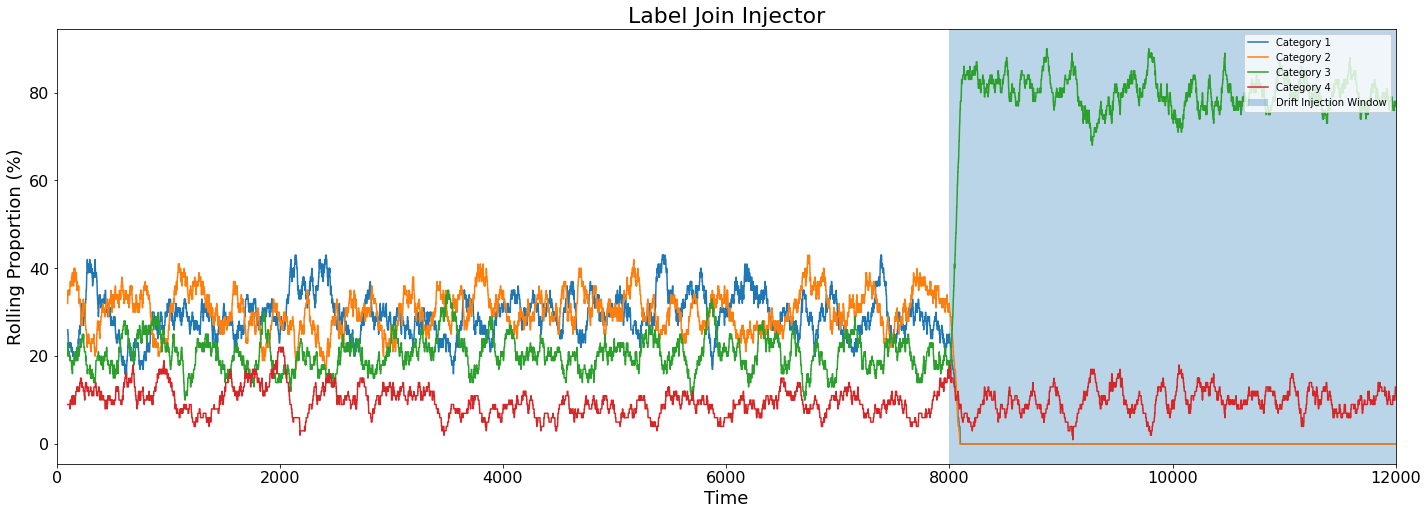

In [40]:
## Plotting ## 

# Obtain rolling proportions of each class 
rolling_rain_1_count = df['cat'].rolling(100).apply(lambda x: (x == 1).sum(),raw = True)
rolling_rain_0_count = df['cat'].rolling(100).apply(lambda x: (x == 0).sum(),raw = True)
rolling_rain_2_count = df['cat'].rolling(100).apply(lambda x: (x == 2).sum(),raw = True)
rolling_rain_3_count = df['cat'].rolling(100).apply(lambda x: (x == 3).sum(),raw = True)

plt.figure(figsize=(24,8))

plt.plot(df.index,rolling_rain_1_count)
plt.plot(df.index,rolling_rain_0_count)
plt.plot(df.index,rolling_rain_2_count)
plt.plot(df.index,rolling_rain_3_count)
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Label Join Injector', fontsize=22)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Rolling Proportion (%)', fontsize=18)
plt.xlim(0,12000)
plt.axvspan(drift_start, drift_end, alpha=0.3, label='Drift Injection Window')
plt.legend(["Category 1","Category 2", "Category 3", "Category 4", "Drift Injection Window"],loc = 'upper right')
plt.show()

### Label Probability Injector

This injector changes the probability of labels. Drift is injected by the user specifying labels and their desired probability. If any classes in the dataset are not specified with a desired probability, they are assigned uniform probability. 

In [41]:
## Setup ##

# Make a copy of original dataframe
df = rainfall_df.copy()

# Identify the column you want to inject drift
col = 'rain'

# Introduce drift injector
injector = LabelProbabilityInjector()

# Inject drift into a dataframe with desired start and end indices
drift_start = 8000
drift_end = 12000

# Setting class probabilities 
class_probabilities = {0: 0.15, 1: (1-0.15)}

# Injector returns new drifted label values 
df['label_drift'] = injector(np.array(pd.DataFrame(df['rain'])), drift_start, drift_end, 0, class_probabilities)

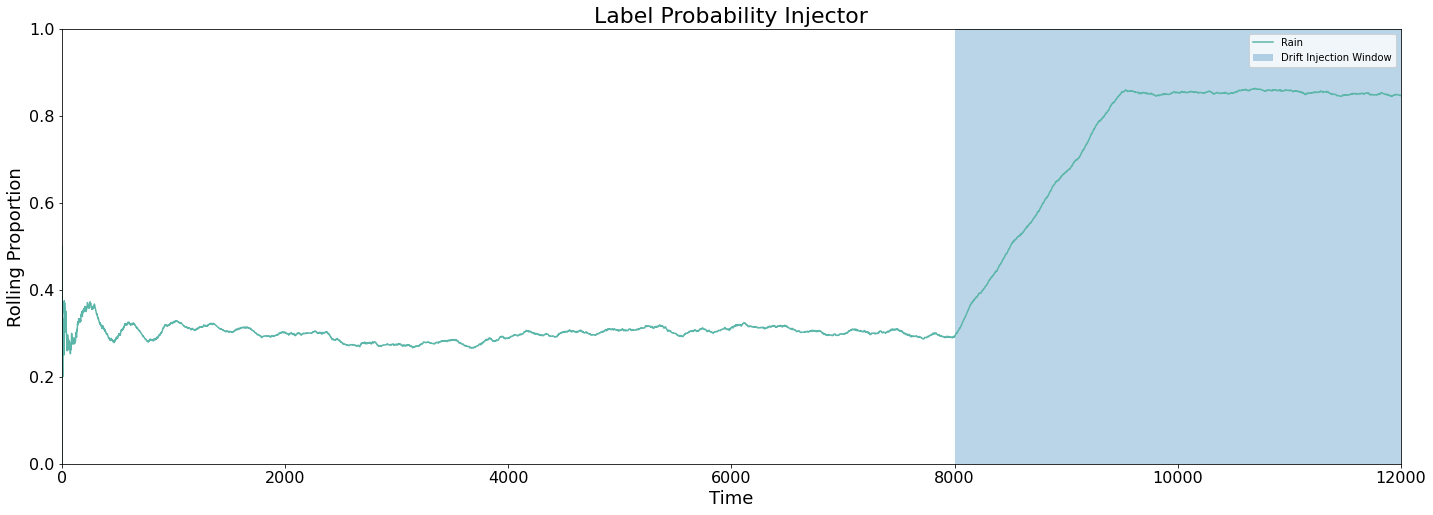

In [42]:
## Ploting ## 

# Obtaining rolling proportions 
df['rolling_mean'] = df['label_drift'].rolling(1500, min_periods=1).mean()
col = 'rolling_mean'

plt.figure(figsize=(24, 8))
plt.plot(df.index, df[col], color = palette[8], label='Rolling Average')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Label Probability Injector', fontsize=22)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Rolling Proportion', fontsize=18)
plt.ylim((0, 1))
plt.xlim(0,12000)
plt.axvspan(drift_start, drift_end, alpha=0.3, label='Drift Injection Window')
plt.legend(["Rain",'Drift Injection Window'],loc = 'upper right')

### Label Dirichlet Injector

This injector changes the probability of labels according to a dirichelt distribution. Drift is injected by the user specifying labels and their desired Dirichlet ratio. All classes must be assigned a specified dirichlet ratio.

In [43]:
## Setup ##

# Make a copy of original dataframe
df = rainfall_df.copy()

# Identify the column you want to inject drift
col = 'rain'

# Introduce drift injector
injector =  LabelDirichletInjector()

# Inject drift into a dataframe with desired start and end indices
# Returns df containing drift 
drift_start = 8000
drift_end = 12000

# Setting Dirichlet Ratio as a proportion of 1:3
df = injector(df,drift_start,drift_end,col,{0:1,1:3})

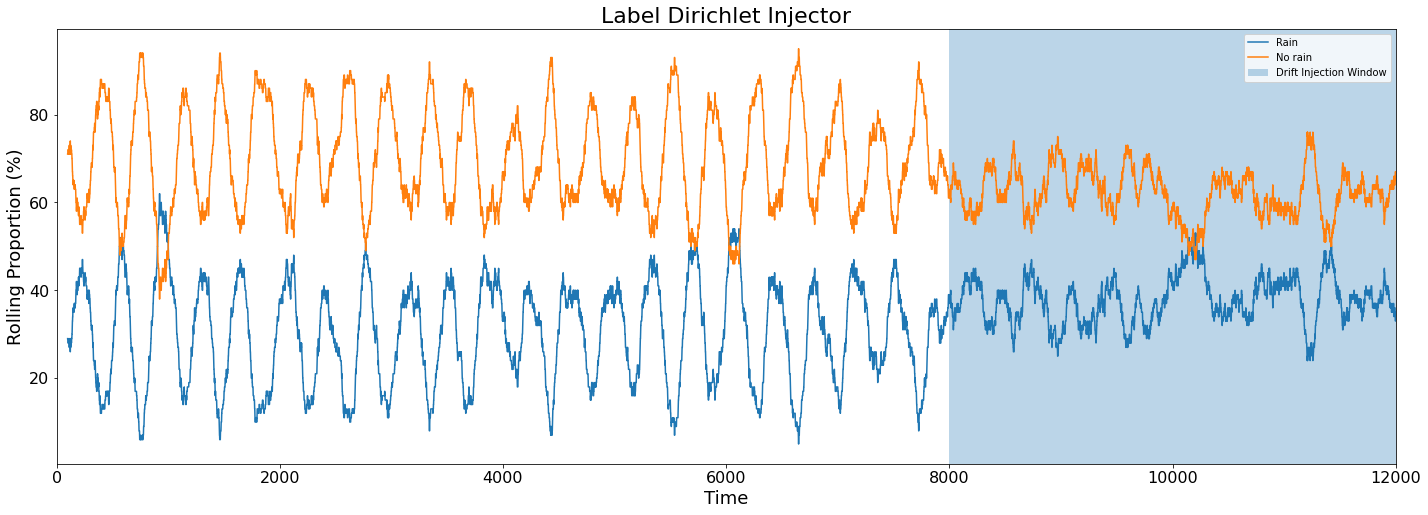

In [44]:
## Plotting ## 

# Obtaining rolling proportions 
rolling_rain_1_count = df['rain'].rolling(100).sum()
rolling_rain_0_count = 100 - rolling_rain_1_count

plt.figure(figsize=(24,8))
plt.plot(df.index,rolling_rain_1_count, label = 'Rain Count')
plt.plot(df.index,rolling_rain_0_count, label = 'No-Rain Count')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Label Dirichlet Injector', fontsize=22)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Rolling Proportion (%)', fontsize=18)
plt.xlim(0,12000)
plt.axvspan(drift_start, drift_end, alpha=0.3, label='Drift Injection Window')
plt.legend(["Rain","No rain", 'Drift Injection Window'],loc = 'upper right')
plt.show()